Install & imports

In [25]:
# If you are on Google Colab, torchaudio is usually preinstalled.
# If needed, uncomment the line below:
# !pip install torchaudio

# Install torchcodec as it seems to be a new dependency for torchaudio's load function
!pip install torchcodec

import os
import glob
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import torchaudio
from torchaudio import transforms

Configuration

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Adjust this to your dataset location
data_root = "/content/drive/MyDrive/Colab Notebooks/Proj Echo/Audio"   # e.g., "/content/data" in Colab, or your local path

sample_rate = 16000       # target sample rate for all audio
clip_duration = 4.0       # seconds per clip (will trim/pad to this length)
num_samples = int(sample_rate * clip_duration)

n_mels = 64
batch_size = 16
num_epochs = 10
learning_rate = 1e-4

class_names = ["ambient", "animal", "random"]
num_classes = len(class_names)
label_to_text = {
    0: "this is Ambience",
    1: "this is animal sound",
    2: "this is random noise",
}


Using device: cpu


Dataset class (audio → Mel spectrogram)

In [27]:
class AudioFolderDataset(Dataset):
    def __init__(self, root_dir, sample_rate=16000, num_samples=48000, n_mels=64):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.num_samples = num_samples

        # Collect file paths and labels
        self.filepaths = []
        self.labels = []

        for label_idx, class_name in enumerate(class_names):
            class_dir = os.path.join(root_dir, class_name)
            pattern = os.path.join(class_dir, "*.wav")
            files = glob.glob(pattern)
            for f in files:
                self.filepaths.append(f)
                self.labels.append(label_idx)

        # Shuffle (optional but good)
        combined = list(zip(self.filepaths, self.labels))
        random.shuffle(combined)
        self.filepaths, self.labels = zip(*combined)

        # Audio transforms: resample -> MelSpectrogram -> dB
        self.resampler = transforms.Resample(orig_freq=None, new_freq=self.sample_rate)
        self.melspec = transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_mels=n_mels
        )
        self.db_transform = transforms.AmplitudeToDB()

    def __len__(self):
        return len(self.filepaths)

    def _load_audio(self, path):
        waveform, sr = torchaudio.load(path)  # waveform: (channels, samples)
        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        # Resample if needed
        if sr != self.sample_rate:
            waveform = self.resampler(waveform)

        # Make sure we have exactly num_samples (pad or trim)
        if waveform.shape[1] < self.num_samples:
            # pad at the end
            pad_amount = self.num_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
        elif waveform.shape[1] > self.num_samples:
            waveform = waveform[:, :self.num_samples]

        return waveform

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        label = self.labels[idx]

        waveform = self._load_audio(filepath)  # (1, num_samples)
        # Mel spectrogram
        mel = self.melspec(waveform)          # (1, n_mels, time)
        mel_db = self.db_transform(mel)       # (1, n_mels, time)
        return mel_db, torch.tensor(label)


Simple CNN classifier

In [28]:
class AudioClassifier(nn.Module):
    def __init__(self, n_mels, num_classes):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        # Global average pooling over freq & time
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (B, 1, n_mels, T)
        x = self.conv_block(x)
        x = self.global_pool(x)  # (B, 64, 1, 1)
        x = x.view(x.size(0), -1)  # (B, 64)
        x = self.fc(x)            # (B, num_classes)
        return x


Create dataset and loaders

In [29]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!ls "/content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio"


ambient  animal  random


In [31]:
import os, glob

data_root = "/content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio"  # adjust if needed

print("data_root =", data_root)
print("Exists?   ", os.path.exists(data_root))
print("Folders in data_root:", os.listdir(data_root))

class_names = ["ambient", "animal", "random"]  # or change to whatever folders you really have

for cls in class_names:
    folder = os.path.join(data_root, cls)
    print(f"\nClass '{cls}' folder:", folder)
    print("  exists?  ", os.path.exists(folder))
    print("  .wav files:", len(glob.glob(os.path.join(folder, "*.wav"))))


data_root = /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio
Exists?    True
Folders in data_root: ['ambient', 'random', 'animal']

Class 'ambient' folder: /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/ambient
  exists?   True
  .wav files: 44

Class 'animal' folder: /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/animal
  exists?   True
  .wav files: 229

Class 'random' folder: /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random
  exists?   True
  .wav files: 46


In [32]:
import random
import torch
from torch.utils.data import Dataset
import torchaudio
from torchaudio import transforms
import torch.nn.functional as F
import glob
import os

class AudioFolderDataset(Dataset):
    def __init__(self, root_dir, class_names,
                 sample_rate=16000, num_samples=48000, n_mels=64):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.num_samples = num_samples
        self.class_names = class_names

        self.filepaths = []
        self.labels = []

        print("=== Scanning dataset ===")
        for label_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            pattern = os.path.join(class_dir, "*.wav")
            files = glob.glob(pattern)

            print(f"Class '{class_name}': folder = {class_dir}")
            print(f"  Found {len(files)} .wav files")

            for f in files:
                self.filepaths.append(f)
                self.labels.append(label_idx)

        if len(self.filepaths) == 0:
            print("WARNING: No audio files found in any class folders!")
            self.filepaths, self.labels = [], []
        else:
            combined = list(zip(self.filepaths, self.labels))
            random.shuffle(combined)
            self.filepaths, self.labels = zip(*combined)

        # Only mel + dB here; resampling will be done per-file in _load_audio
        self.melspec = transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_mels=n_mels
        )
        self.db_transform = transforms.AmplitudeToDB()

    def __len__(self):
        return len(self.filepaths)

    def _load_audio(self, path):
        try:
            waveform, sr = torchaudio.load(path)   # (channels, samples)
        except RuntimeError as e:
            print(f"ERROR: Failed to load audio file: {path} - {e}")
            # Return a dummy waveform to allow processing to continue, or re-raise
            # For now, let's return a zero tensor of expected shape
            return torch.zeros(1, self.num_samples)

        # mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # resample IF needed, with a proper orig_freq
        if sr != self.sample_rate:
            resampler = transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)

        # pad/trim
        if waveform.shape[1] < self.num_samples:
            pad_amount = self.num_samples - waveform.shape[1]
            waveform = F.pad(waveform, (0, pad_amount))
        elif waveform.shape[1] > self.num_samples:
            waveform = waveform[:, :self.num_samples]

        return waveform

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        label = self.labels[idx]

        waveform = self._load_audio(filepath)
        mel = self.melspec(waveform)
        mel_db = self.db_transform(mel)
        return mel_db, torch.tensor(label)

Now create the dataset and loaders (with a safety check)


In [33]:
dataset = AudioFolderDataset(
    root_dir=data_root,
    class_names=class_names,
    sample_rate=sample_rate,
    num_samples=num_samples,
    n_mels=n_mels,
)

print("Total samples:", len(dataset))

if len(dataset) == 0:
    raise RuntimeError("Dataset is empty. Fix the path / folder names / file extensions above.")

val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

from torch.utils.data import DataLoader, random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print("Train size:", len(train_ds))
print("Val size  :", len(val_ds))

=== Scanning dataset ===
Class 'ambient': folder = /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/ambient
  Found 44 .wav files
Class 'animal': folder = /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/animal
  Found 229 .wav files
Class 'random': folder = /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random
  Found 46 .wav files
Total samples: 319
Train size: 256
Val size  : 63


In [34]:
dataset = AudioFolderDataset(
    root_dir=data_root,
    class_names=class_names,   # ["ambient", "animal", "random"]
    sample_rate=sample_rate,
    num_samples=num_samples,
    n_mels=n_mels,
)

print("Total samples:", len(dataset))

val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

from torch.utils.data import DataLoader, random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print("Train size:", len(train_ds))
print("Val size  :", len(val_ds))

=== Scanning dataset ===
Class 'ambient': folder = /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/ambient
  Found 44 .wav files
Class 'animal': folder = /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/animal
  Found 229 .wav files
Class 'random': folder = /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random
  Found 46 .wav files
Total samples: 319
Train size: 256
Val size  : 63


Training loop

In [35]:
model = AudioClassifier(n_mels=n_mels, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for mel_db, labels in train_loader:
        mel_db = mel_db.to(device)         # (B, 1, n_mels, T)
        labels = labels.to(device)         # (B,)

        optimizer.zero_grad()
        outputs = model(mel_db)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for mel_db, labels in val_loader:
            mel_db = mel_db.to(device)
            labels = labels.to(device)
            outputs = model(mel_db)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f} "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f}"
    )

# Save the trained model
torch.save(model.state_dict(), "audio_classifier.pth")
print("Model saved as audio_classifier.pth")

Epoch [1/10] Train Loss: 1.1386, Train Acc: 0.219 Val Loss: 1.0824, Val Acc: 0.444
Epoch [2/10] Train Loss: 1.0626, Train Acc: 0.398 Val Loss: 1.0565, Val Acc: 0.413
Epoch [3/10] Train Loss: 1.0094, Train Acc: 0.449 Val Loss: 1.0067, Val Acc: 0.460
Epoch [4/10] Train Loss: 0.9691, Train Acc: 0.527 Val Loss: 0.9494, Val Acc: 0.635
Epoch [5/10] Train Loss: 0.9300, Train Acc: 0.633 Val Loss: 0.9131, Val Acc: 0.778
Epoch [6/10] Train Loss: 0.8959, Train Acc: 0.719 Val Loss: 0.8873, Val Acc: 0.762
Epoch [7/10] Train Loss: 0.8848, Train Acc: 0.762 Val Loss: 0.8646, Val Acc: 0.730
Epoch [8/10] Train Loss: 0.8522, Train Acc: 0.750 Val Loss: 0.8535, Val Acc: 0.778
Epoch [9/10] Train Loss: 0.8346, Train Acc: 0.762 Val Loss: 0.8353, Val Acc: 0.778
Epoch [10/10] Train Loss: 0.8178, Train Acc: 0.762 Val Loss: 0.8222, Val Acc: 0.794
Model saved as audio_classifier.pth


testing

In [36]:
import os, glob, random

# CHANGE THIS to the folder on Drive that has your random .wav files
test_folder = "/content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random"  # example

print("Folder exists?", os.path.exists(test_folder))

wav_files = glob.glob(os.path.join(test_folder, "*.wav"))
print("Found", len(wav_files), "wav files")

for i, f in enumerate(wav_files):
    print(i, "->", f)


Folder exists? True
Found 46 wav files
0 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/dog1.wav
1 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/dog-bark3.wav
2 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/cat1.wav
3 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/cat2.wav
4 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/duck1.wav
5 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/horse2.wav
6 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/dog_bark2.wav
7 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/dog2.wav
8 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/horse1.wav
9 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/brown.wav
10 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/campfire.wav
11 -> /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/beach.wav
12 -> /content/drive/MyDri

In [37]:
import torchaudio
from torchaudio import transforms
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Audio as IPyAudio

def visualize_and_predict_one(filepath):
    print("\n=== File:", filepath, "===")

    # ---------- load ----------
    waveform, sr = torchaudio.load(filepath)   # (channels, samples)

    # mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # resample if needed
    if sr != sample_rate:
        resampler = transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)
        sr = sample_rate

    # pad/trim
    if waveform.shape[1] < num_samples:
        pad_amount = num_samples - waveform.shape[1]
        waveform = F.pad(waveform, (0, pad_amount))
    elif waveform.shape[1] > num_samples:
        waveform = waveform[:, :num_samples]

    # ---------- mel spectrogram ----------
    melspec = transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)
    db_transform = transforms.AmplitudeToDB()

    mel = melspec(waveform)           # (1, n_mels, T)
    mel_db = db_transform(mel)        # (1, n_mels, T)

    # ---------- prediction ----------
    model.eval()
    with torch.no_grad():
        inp = mel_db.unsqueeze(0).to(device)   # (1, 1, n_mels, T)
        outputs = model(inp)
        pred_idx = outputs.argmax(dim=1).item()
        pred_text = label_to_text[pred_idx]

    print("Model prediction:", pred_text)

    # ---------- visualise waveform ----------
    plt.figure(figsize=(12, 3))
    plt.title(f"Waveform (sr={sr})")
    plt.plot(waveform.squeeze().cpu().numpy())
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    # ---------- visualise Mel-spectrogram ----------
    mel_np = mel_db.squeeze(0).cpu().numpy()  # (n_mels, T)

    plt.figure(figsize=(12, 4))
    plt.title("Mel-spectrogram (dB)")
    plt.imshow(mel_np, origin="lower", aspect="auto")
    plt.xlabel("Time frames")
    plt.ylabel("Mel bins")
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()

    # ---------- play audio ----------
    display(IPyAudio(filepath))

    return pred_text



Randomly chosen file: /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/horse1__campfire.wav

=== File: /content/drive/MyDrive/Colab_Notebooks/Proj_Echo/Audio/random/horse1__campfire.wav ===
Model prediction: this is animal sound


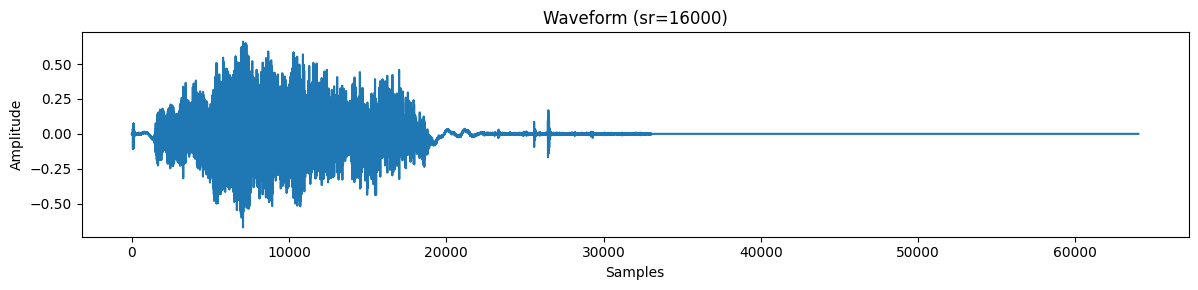

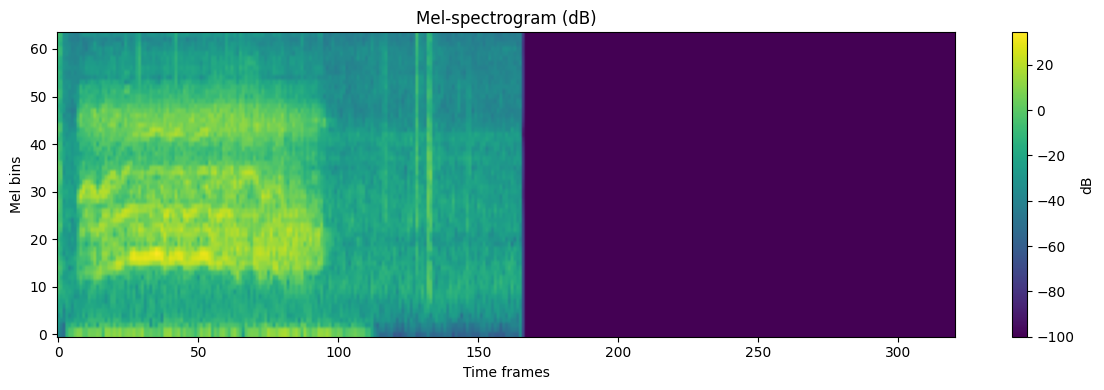

In [39]:
if len(wav_files) == 0:
    raise RuntimeError("No .wav files found in the test_folder")

test_file = random.choice(wav_files)   # randomly choose one
print("Randomly chosen file:", test_file)

_ = visualize_and_predict_one(test_file)


Validation Accuracy Code

In [40]:
import torch
import torch.nn as nn

def evaluate_model(model, val_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for mel_db, labels in val_loader:
            mel_db = mel_db.to(device)
            labels = labels.to(device)

            outputs = model(mel_db)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)

            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {accuracy*100:.2f}%")

    return avg_loss, accuracy


In [43]:
val_loss, val_accuracy = evaluate_model(model, val_loader, device)


Validation Loss: 0.8222
Validation Accuracy: 79.37%


Compute accuracy on the entire dataset
If you want accuracy on all data

In [42]:
from torch.utils.data import DataLoader

full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
full_loss, full_accuracy = evaluate_model(model, full_loader, device)

print(f"Overall accuracy: {full_accuracy*100:.2f}%")


Validation Loss: 0.8021
Validation Accuracy: 76.49%
Overall accuracy: 76.49%
